In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *
from analysis.activations import make_dataset_df
from explain import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [6]:
universal_neuron_df = pd.read_csv(f'dataframes/interpretable_neurons/{model_name}/universal.csv')

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
vocab_df = pd.read_csv('dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

In [7]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

In [8]:
from analysis.activations import make_dataset_df
from analysis.vocab_df import create_normalized_vocab

dataset_df = make_dataset_df(ds, decoded_vocab)
decoded_norm_vocab, token_ix_2_normed_ix = create_normalized_vocab(vocab_df, decoded_vocab)

unigram_df = get_unigram_df(
    dataset_df, decoded_norm_vocab, token_ix_2_normed_ix)

In [9]:
dataset_df['normed_token'] = dataset_df['token'].apply(lambda x: token_ix_2_normed_ix[x])

In [10]:

var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

In [11]:
best_df = pd.concat([var_red_df.max(axis=1), var_red_df.idxmax(axis=1)], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'variance_reduction', 1: 'feature'})\
    .reset_index()

best_df['layer'] = best_df['neuron'].apply(lambda x: int(x.split('.')[0]))
best_df['neuron'] = best_df['neuron'].apply(lambda x: int(x.split('.')[1]))
best_df = best_df[['layer', 'neuron', 'variance_reduction', 'feature']]

In [10]:
join_df = neuron_df.join(best_df.set_index(['layer', 'neuron']), on=['layer', 'neuron'], how='inner').sort_values('variance_reduction', ascending=False)#.query('layer == 9').style.background_gradient(axis=0)
join_df.head(20).style.background_gradient(axis=0)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,variance_reduction,feature
3270,0,3270,0.995000,0.988225,0.968300,0.313700,0.258800,0.285700,0.341519,-0.458929,0.419560,-0.093457,0.292665,-0.615681,0.320870,6.185521,49.890865,-0.000083,0.001459,1.003831,6.778793,0.034329,0.986861,to_unigram
4027,0,4027,0.988300,0.965775,0.944300,0.261200,0.234100,0.247425,0.382962,-0.517760,0.410381,-0.051761,0.315072,-0.672537,0.266199,6.221529,52.153736,-0.000507,0.001019,0.493277,4.599477,0.027697,0.976100,in_unigram
3954,0,3954,0.978000,0.960575,0.941000,0.214800,0.160500,0.188000,0.376250,-0.492060,0.388862,-0.043645,0.292778,-0.897537,0.209004,4.159611,37.739380,0.000471,0.000870,0.108079,3.366423,0.026092,0.969911,for_unigram
3953,0,3953,0.998000,0.995650,0.993000,0.388000,0.362000,0.377675,0.338841,-0.464002,0.424265,-0.161833,0.294814,-0.451912,0.500945,4.423555,23.642336,0.000136,0.000908,0.283957,3.825266,0.065130,0.967139,contains_comma
4212,1,116,0.975600,0.967725,0.949000,0.300300,0.239100,0.278000,0.420413,-1.046302,0.363043,0.529294,0.308547,-1.293949,0.300287,3.174604,21.453880,-0.000011,0.001475,1.345210,7.782014,0.014410,0.962920,to_unigram
3825,0,3825,0.957500,0.930025,0.888000,0.254400,0.221600,0.239400,0.380227,-0.486248,0.393062,-0.056488,0.299070,-0.568703,0.236762,4.338547,30.661678,-0.000099,0.001831,-0.548477,3.418531,0.057021,0.957958,a_unigram
6600,1,2504,0.972700,0.876925,0.700000,0.308000,0.264400,0.286700,0.406215,-0.972122,0.382917,0.591598,0.311636,-1.094341,0.340599,3.758569,22.738125,0.000212,0.001027,0.336573,3.769807,0.026217,0.955042,is_one_digit
891,0,891,0.977000,0.972650,0.968000,0.362000,0.283200,0.312700,0.337752,-0.339625,0.369809,-0.018560,0.250835,-0.519705,0.203219,4.106842,26.781069,0.000012,0.000950,0.018223,2.995720,0.073962,0.954941,of_unigram
2962,0,2962,0.995000,0.994000,0.992700,0.360600,0.328100,0.342450,0.315865,-0.497963,0.397345,0.020245,0.257653,-0.564270,0.503282,3.830324,19.183449,-0.000229,0.001483,0.636134,4.818747,0.060182,0.949867,contains_period
4641,1,545,0.985400,0.971375,0.952600,0.360800,0.340000,0.350975,0.485292,-1.178853,0.344364,0.474745,0.354095,-1.271540,0.593618,2.804875,14.286317,0.000281,0.001455,0.184837,3.572542,0.031211,0.946422,the_unigram


In [12]:
def make_unigram_feature_family_data(
    ds, top_var_red_df, feature_df, decoded_vocab, feature_family, 
    variance_threshold=0.5, model='stanford-gpt2-medium-a', dataset='pile.test.all-10m.512'):
    family = top_var_red_df.query('(feature == @feature_family) and (variance_reduction > @variance_threshold)')
    family_neurons = family[['layer', 'neuron']].values

    dataset_df = make_dataset_df(ds, decoded_vocab)
    family_df, neuron_cols = make_activation_df(
        dataset_df, 'cached_activations', model, dataset, -1, 
        family_neurons, use_post=False
    )
    family_df['feature'] = family_df.token.isin(feature_df[feature_df[feature_family]].index)

    family_df['next_token'] = family_df.token.shift(-1).fillna(-1).astype(int)
    family_df['next_token_no_space'] = family_df.next_token.isin(vocab_df[vocab_df.start_w_no_space & vocab_df.all_alpha].index)
    family_df['current_token_no_space'] = family_df.token.isin(vocab_df[vocab_df.start_w_no_space].index)
    return family_df, neuron_cols

def make_unigram_neuron_plot_data(
    ds, top_var_red_df, feature_df, decoded_vocab, layer, neuron, feature,
    variance_threshold=0.5, model='stanford-gpt2-medium-a', dataset='pile.test.all-10m.512'):
    family = top_var_red_df.query('(layer == @layer) and (neuron == @neuron) and (variance_reduction > @variance_threshold)')
    family_neurons = family[['layer', 'neuron']].values

    dataset_df = make_dataset_df(ds, decoded_vocab)
    family_df, neuron_cols = make_activation_df(
        dataset_df, 'cached_activations', model, dataset, -1, 
        family_neurons, use_post=False
    )
    family_df['feature'] = family_df.token.isin(feature_df[feature_df[feature]].index)

    family_df['next_token'] = family_df.token.shift(-1).fillna(-1).astype(int)
    family_df['next_token_no_space'] = family_df.next_token.isin(vocab_df[vocab_df.start_w_no_space & vocab_df.all_alpha].index)
    family_df['current_token_no_space'] = family_df.token.isin(vocab_df[vocab_df.start_w_no_space].index)
    return family_df, neuron_cols

In [13]:
from analysis.plots import *

def plot_unigram_neuron(neuron_df, neuron_col, feature_name, ax=None):
    classes = np.ones(len(neuron_df), dtype='int') + 2

    is_feature_token = neuron_df.feature.values
    next_token_no_space = neuron_df.next_token_no_space.values
    current_token_no_space = neuron_df.current_token_no_space.values

    classes[is_feature_token] = 0
    classes[is_feature_token & next_token_no_space] = 1
    classes[is_feature_token & current_token_no_space] = 2

    class_labels = [feature_name, 'beginning of word', 'middle of word', 'other']

    # kde plot per neuron
    n_bins =100
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    values = neuron_df[neuron_col].values
    token_histogram_by_class(values, classes, class_labels, ax=ax)


def plot_unigram_neuron_family(family_df, neuron_cols, feature_family):
    classes = np.ones(len(family_df), dtype='int') + 2

    is_feature_token = family_df.feature.values
    next_token_no_space = family_df.next_token_no_space.values
    current_token_no_space = family_df.current_token_no_space.values

    classes[is_feature_token] = 0
    classes[is_feature_token & next_token_no_space] = 1
    classes[is_feature_token & current_token_no_space] = 2

    class_labels = [feature_family, 'beginning of word', 'middle of word', 'other']

    # kde plot per neuron
    n_bins =100
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    n_cols = min(4, len(neuron_cols))
    n_rows = int(np.ceil(len(neuron_cols) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

    for ix, neuron_col in enumerate(neuron_cols):
        values = family_df[neuron_col].values
        if len(neuron_cols) == n_cols:
            ax = axs[ix]
        else:
            ax = axs[ix // n_cols, ix % n_cols]
        token_histogram_by_class(values, classes, class_labels, ax=ax)
        ax.set_title(f'Neuron {neuron_col}')

    plt.tight_layout()


In [14]:
def plot_vocab_neuron_family(family_df, neuron_cols, feature_family):
    classes = np.ones(len(family_df), dtype='int') + 2

    classes = (~family_df.feature.values).astype(int)

    class_labels = [feature_family, 'other']

    # kde plot per neuron
    n_bins = 100
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    n_cols = min(4, len(neuron_cols))
    n_rows = int(np.ceil(len(neuron_cols) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

    for ix, neuron_col in enumerate(neuron_cols):
        values = family_df[neuron_col].values
        if len(neuron_cols) == n_cols:
            ax = axs[ix]
        else:
            ax = axs[ix // n_cols, ix % n_cols]
        token_histogram_by_class(values, classes, class_labels, ax=ax)
        ax.set_title(f'Neuron {neuron_col}')

    plt.tight_layout()

def plot_vocab_neuron(neuron_df, neuron_col, feature_name, ax=None, logy=False, plot_dist=True):
    classes = (~neuron_df.feature.values).astype(int)

    class_labels = ['true', 'false']

    # kde plot per neuron
    n_bins = 100
    colors = ['tab:blue', 'tab:orange']

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    values = neuron_df[neuron_col].values
    token_histogram_by_class(
        values, classes, class_labels, ax=ax, 
        legend_loc='upper left', legend_title='', logy=logy, plot_dist=plot_dist)

In [14]:
token_feature_families = list(best_df.sort_values('variance_reduction').query('variance_reduction > 0.5').feature.value_counts().head(30).index)

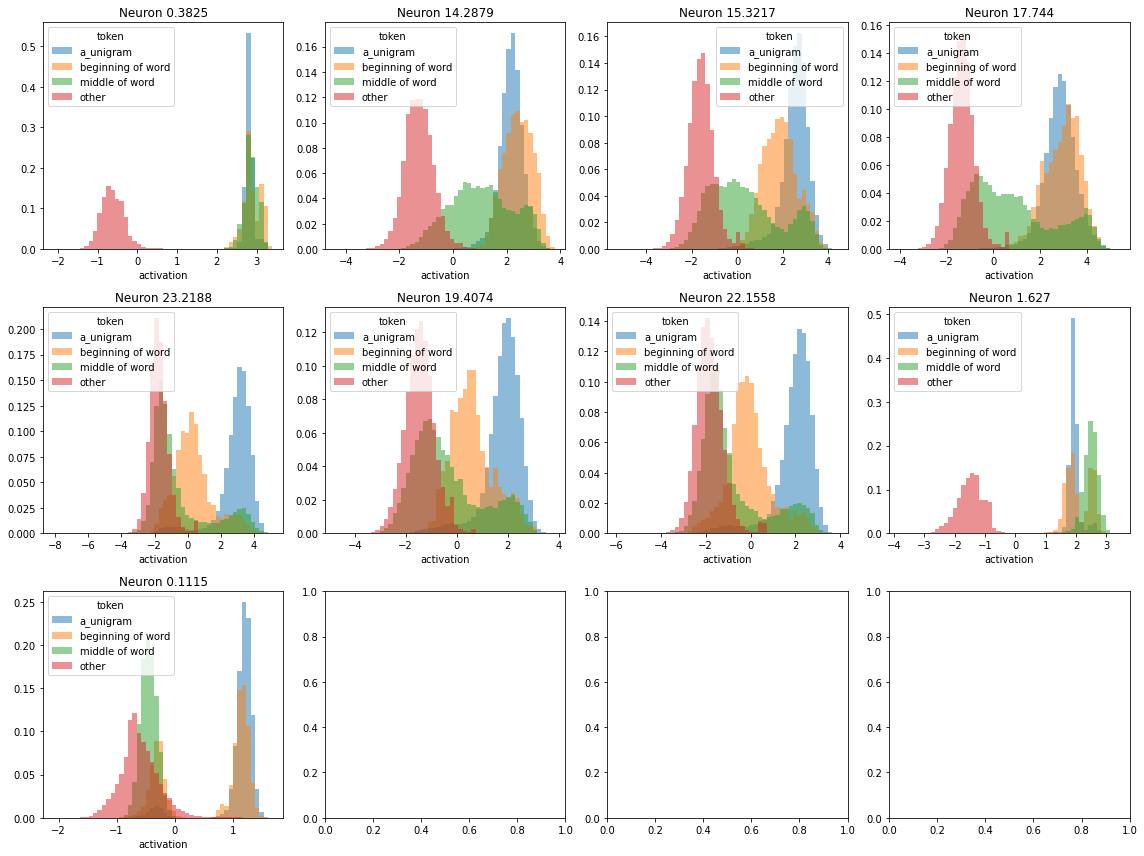

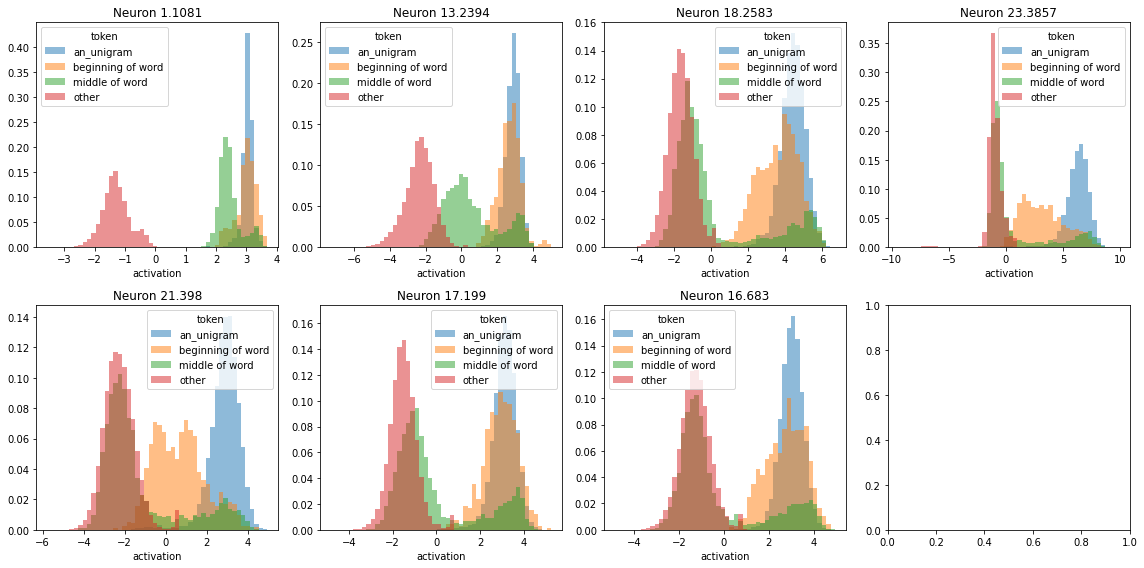

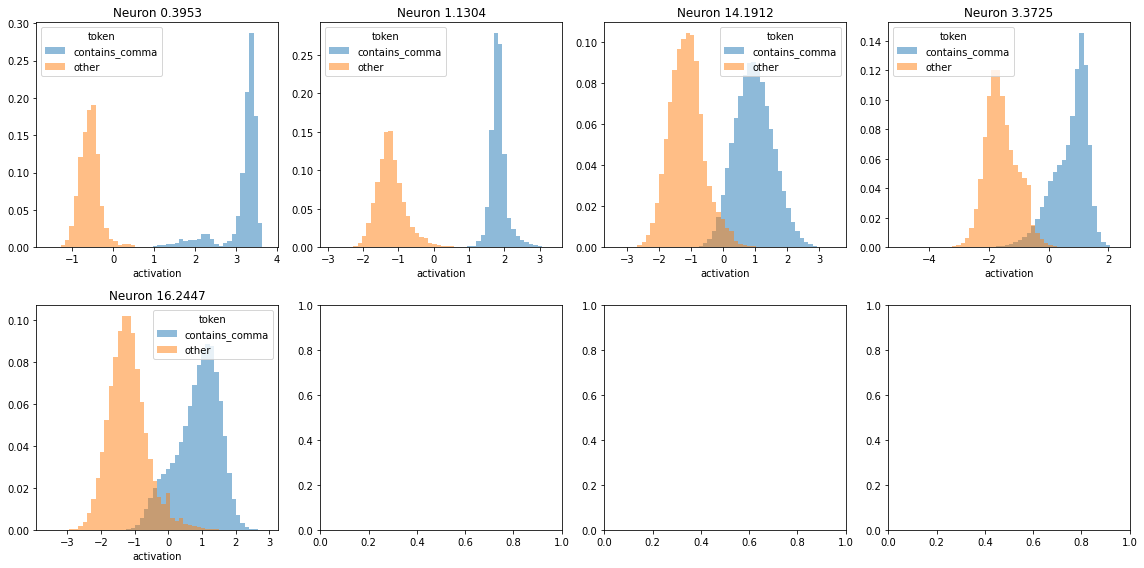

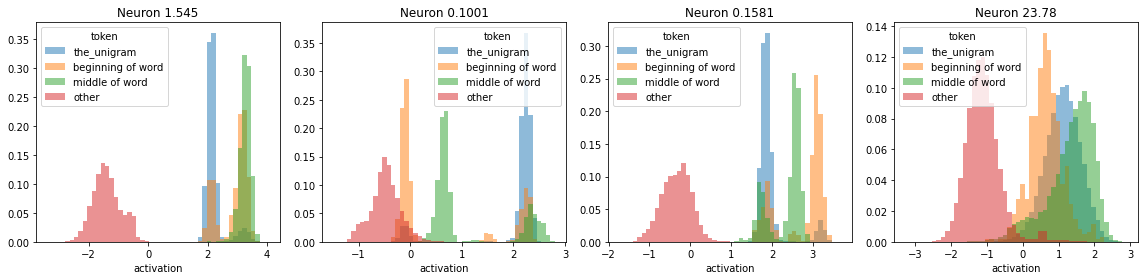

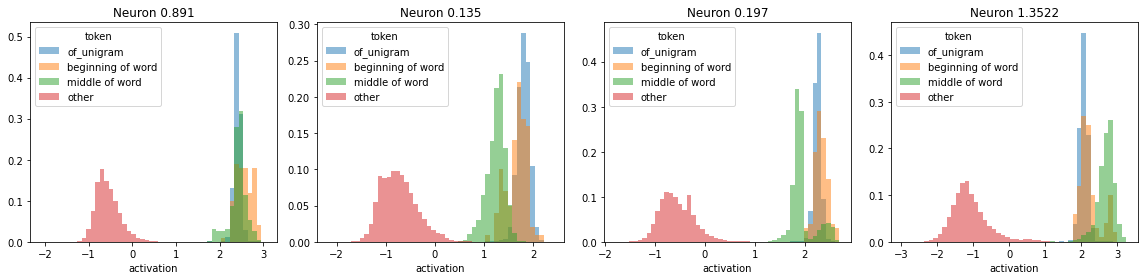

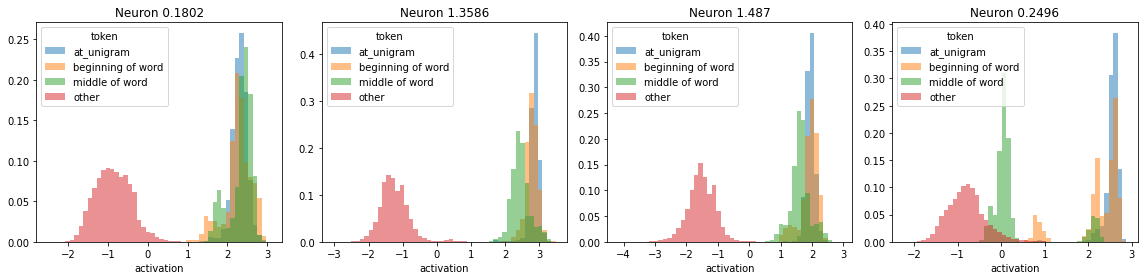

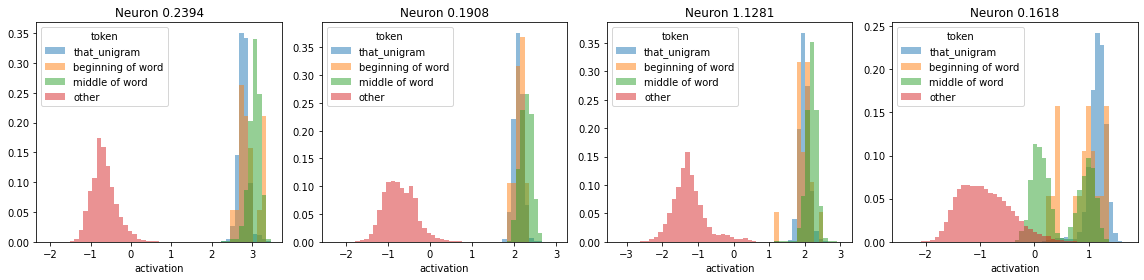

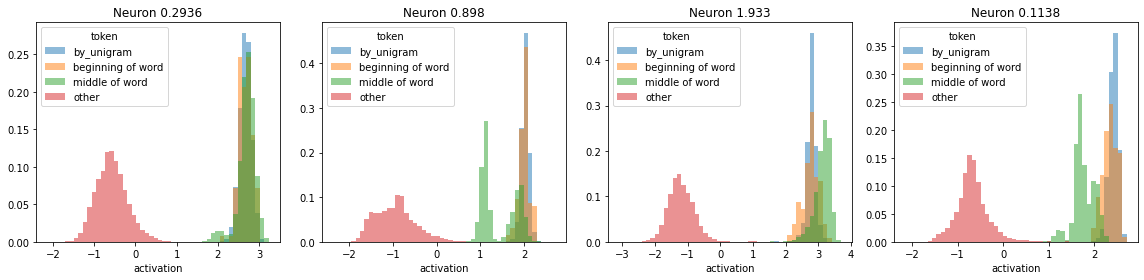

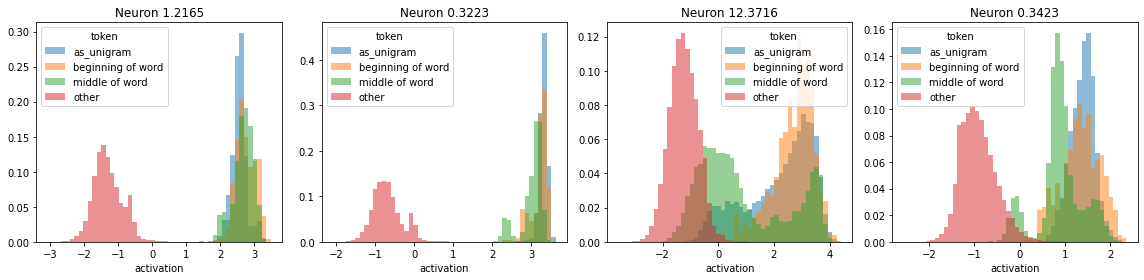

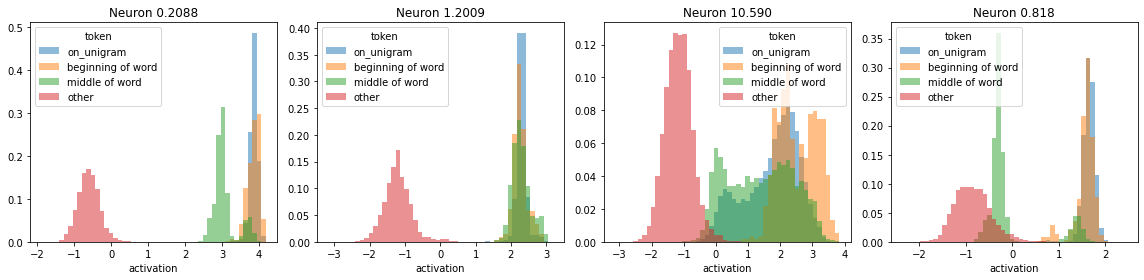

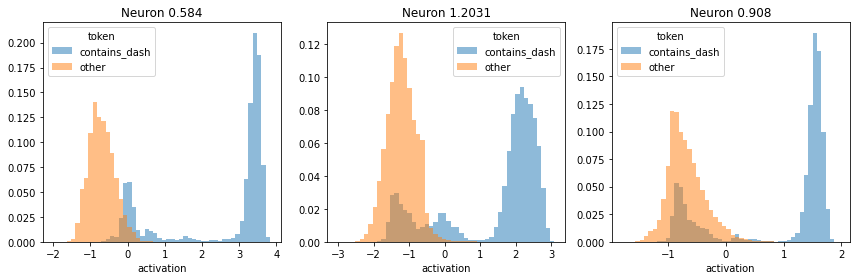

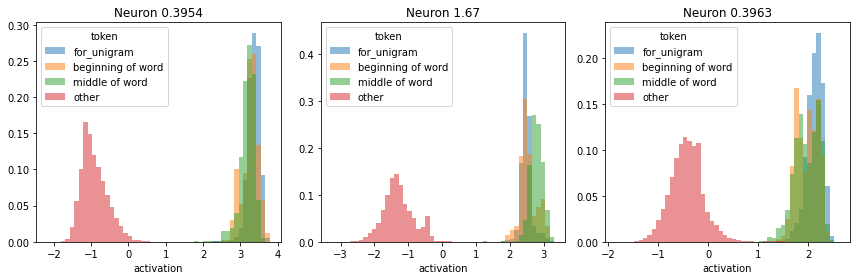

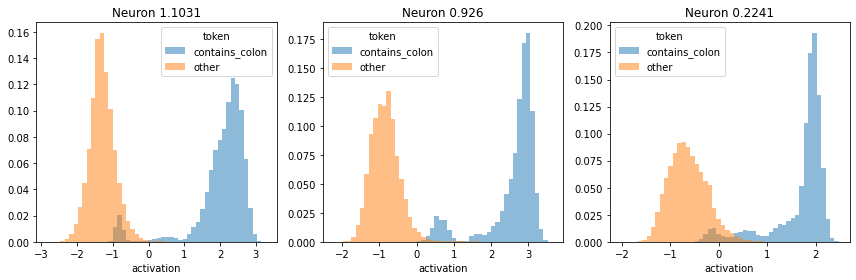

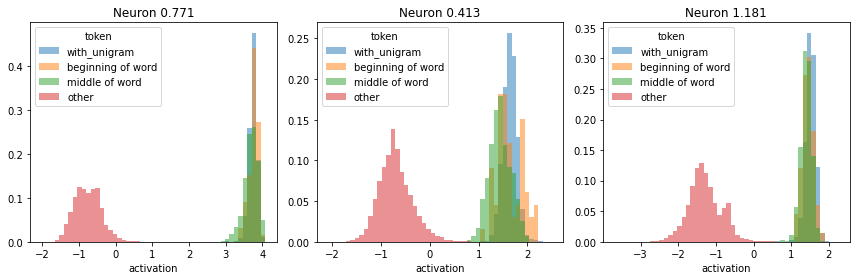

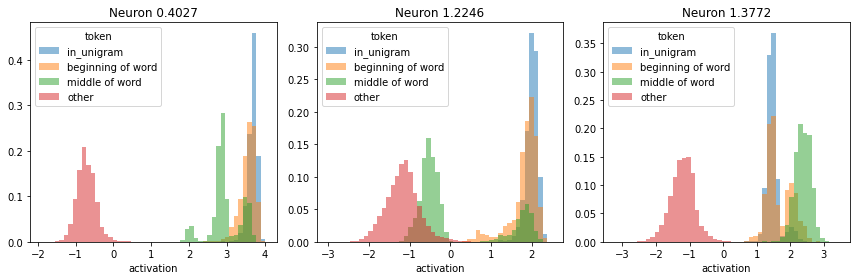

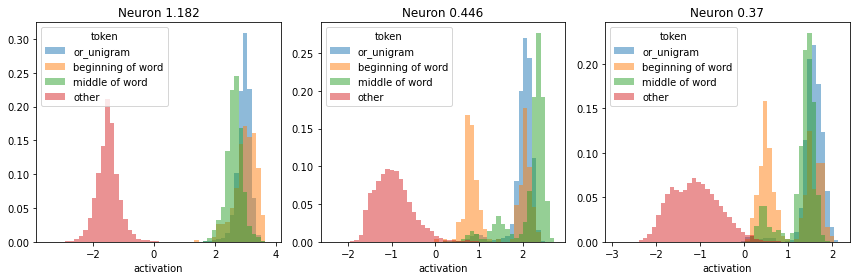

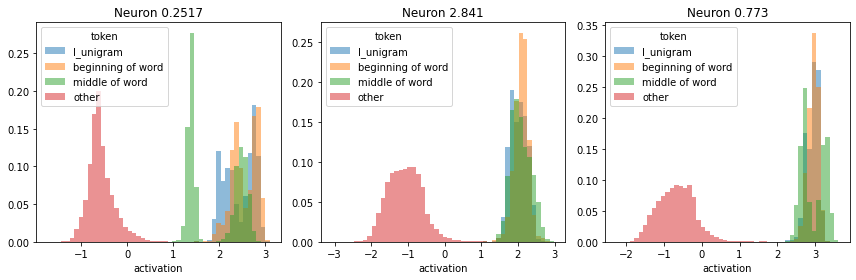

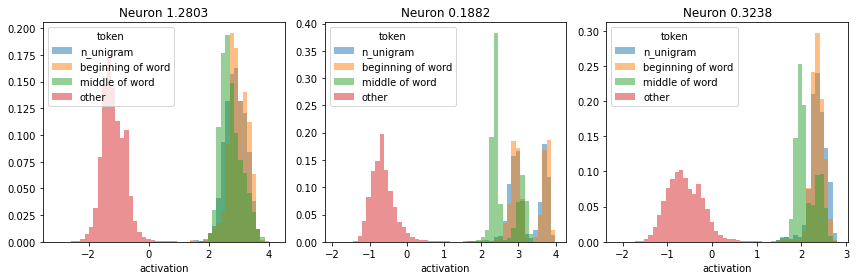

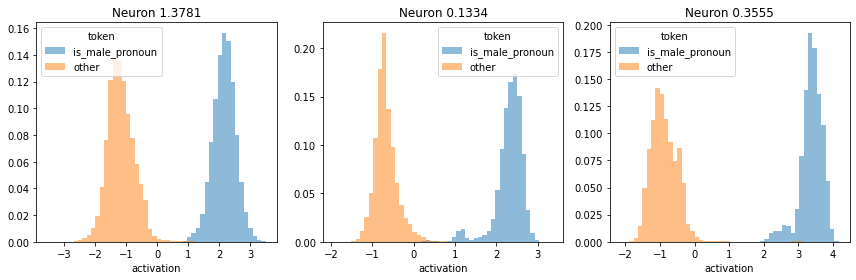

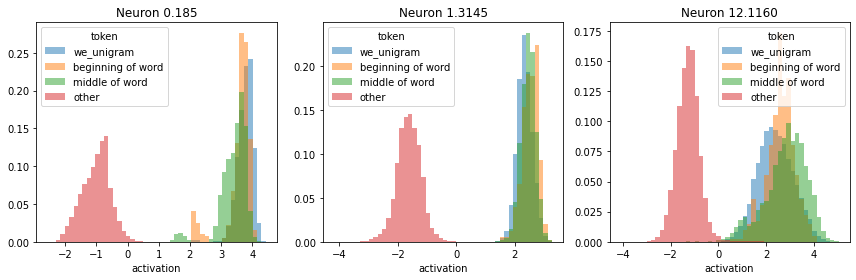

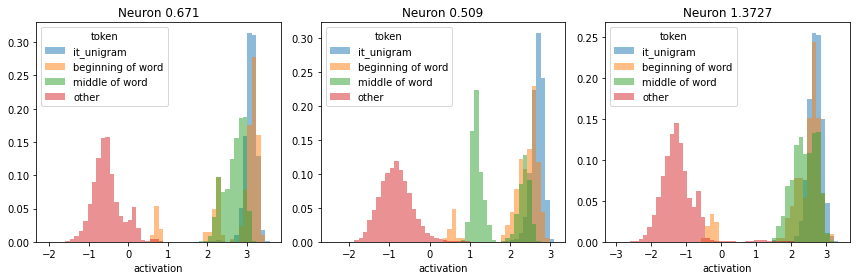

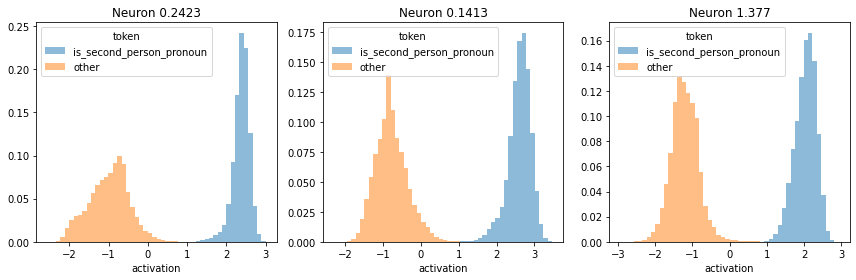

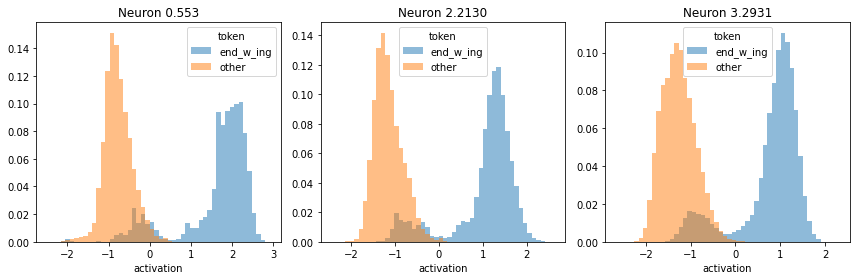

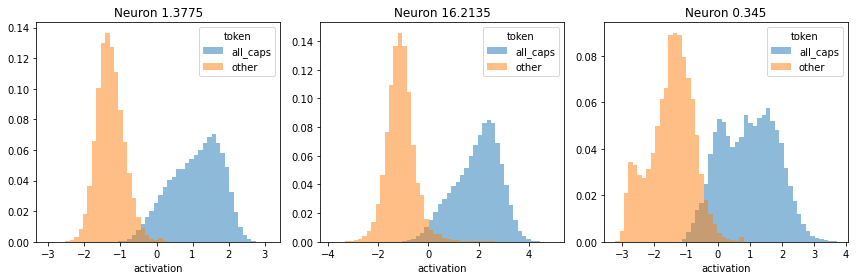

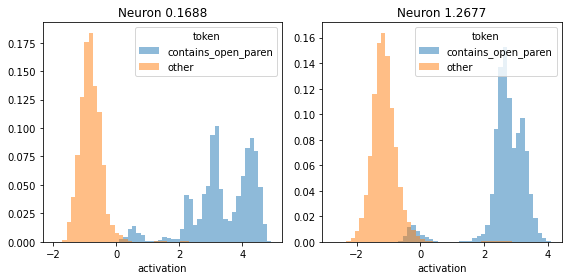

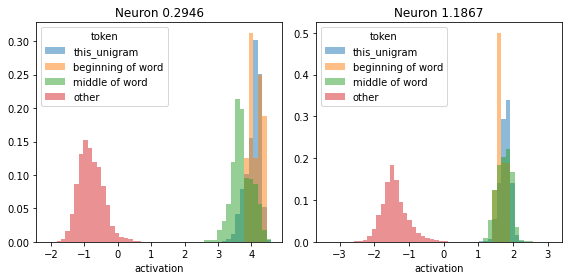

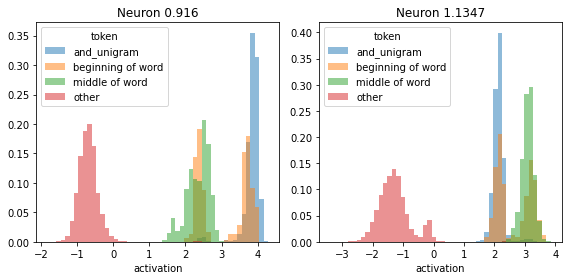

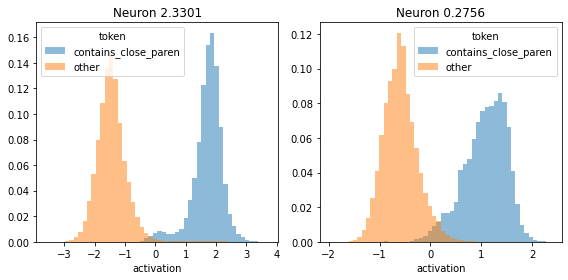

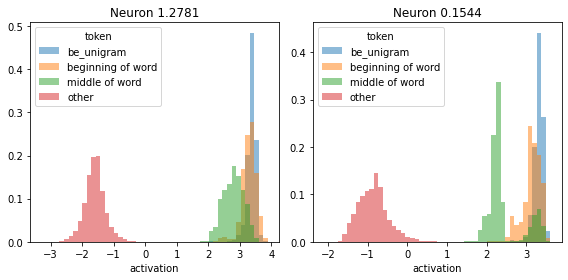

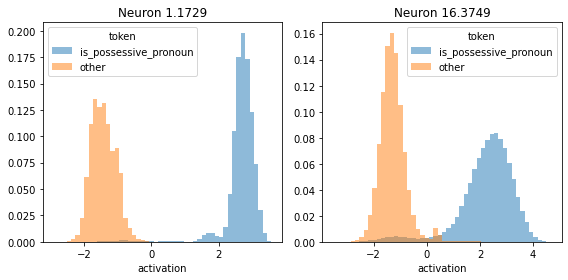

In [ ]:
for feature in token_feature_families:
    if feature in unigram_df.columns:
        family_df, neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, feature)
    
        plot_unigram_neuron_family(family_df, neuron_cols, feature)
    else:
        family_df, neuron_cols = make_unigram_feature_family_data(
            ds, best_df, vocab_df, decoded_vocab, feature)
    
        plot_vocab_neuron_family(family_df, neuron_cols, feature)      

    plt.show()

In [15]:
def plot_unigram_neuron_family_boxenplot(family_df, neuron_cols, feature_family, ax=None, is_test=False):
    classes = np.ones(len(family_df), dtype='int') + 2

    is_feature_token = family_df.feature.values
    next_token_no_space = family_df.next_token_no_space.values
    current_token_no_space = family_df.current_token_no_space.values

    classes[is_feature_token] = 0
    classes[is_feature_token & next_token_no_space] = 1
    classes[is_feature_token & current_token_no_space] = 2

    class_labels = ['as word', 'beginning of word', 'middle of word', 'other token']

    family_df['class'] = classes

    melted_family_df = family_df.melt(
        id_vars=['class'], value_vars=neuron_cols, 
        var_name='neuron', value_name='activation'
    )
    if is_test:
        melted_family_df = melted_family_df.sample(100_000)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sns.boxenplot(
        x='neuron', y='activation', hue='class', data=melted_family_df, ax=ax,
        palette=colors, hue_order=[0, 1, 2, 3], showfliers=False, order=sorted(neuron_cols)
    )
    ax.legend(title='unigram token')
    # set legend labels to class labels
    for ix, label in enumerate(class_labels):
        ax.get_legend().get_texts()[ix].set_text(label)
    
    ax.set_ylabel('pre-activation')
    ax.set_title(f'{feature_family.replace("_", " ")} neurons')
        

In [16]:
family_df, neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, 'an_unigram')

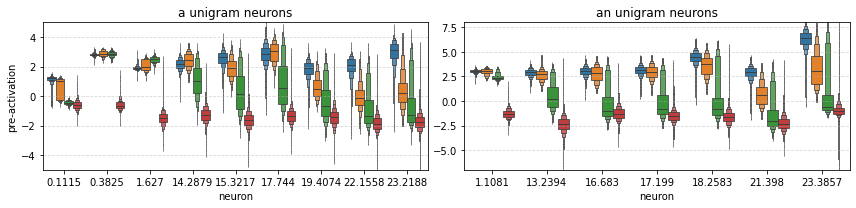

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

a_family_df, a_neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, 'a_unigram')
plot_unigram_neuron_family_boxenplot(a_family_df, a_neuron_cols, 'a_unigram', ax=axs[0])


an_family_df, an_neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, 'an_unigram')
plot_unigram_neuron_family_boxenplot(an_family_df, an_neuron_cols, 'an_unigram', ax=axs[1])
axs[1].set_ylabel('')

for ax in axs:
    ax.grid(axis='y', alpha=0.5, linestyle='--')
    ax.get_legend().remove()

axs[0].set_ylim(-5, 5)
axs[1].set_ylim(-7, 8)

plt.tight_layout()

plt.savefig('figures/unigram_duplicate_neurons_a_an.png', dpi=75, bbox_inches='tight')

In [17]:
family_counts = best_df.sort_values('variance_reduction').query('variance_reduction > 0.5').feature.value_counts()
duplicate_unigram_families = list(family_counts[family_counts >= 3].index)[2:]
duplicate_unigram_families = [feature for feature in duplicate_unigram_families if feature in unigram_df.columns]

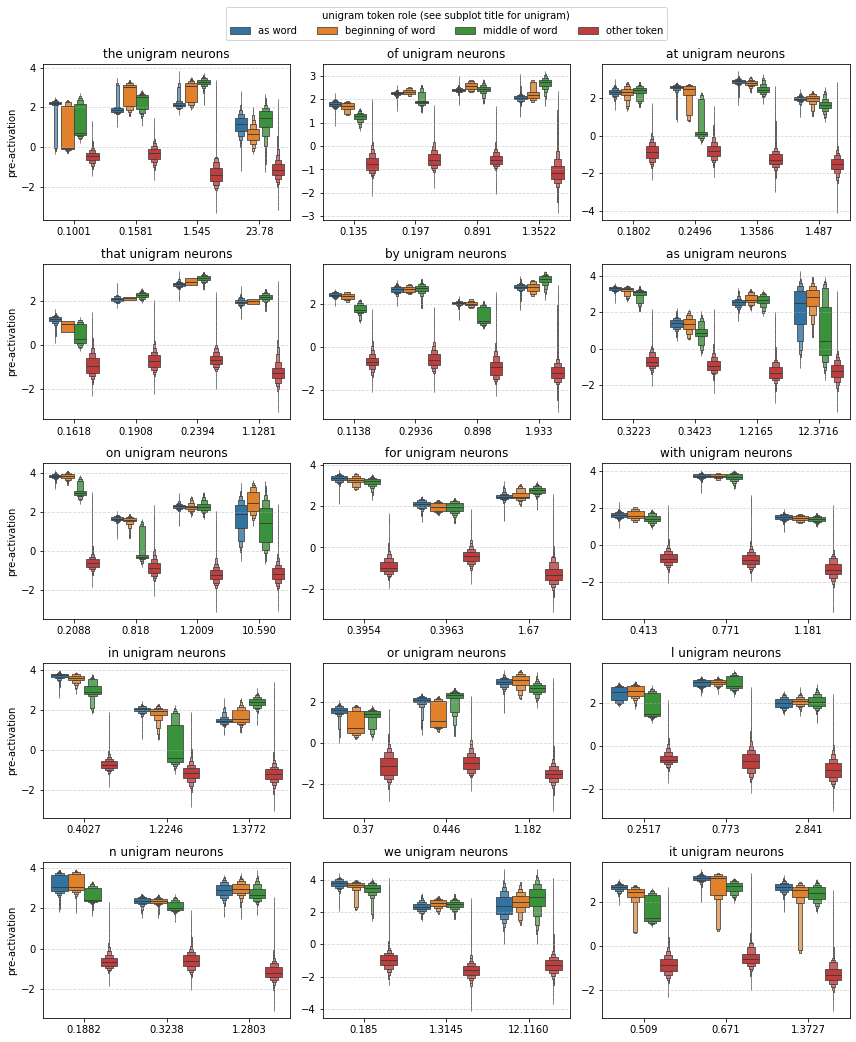

In [36]:
class_labels = ['as word', 'beginning of word', 'middle of word', 'other token']

fig, axs = plt.subplots(5, 3, figsize=(12, 14))
for ix, family in enumerate(duplicate_unigram_families):
    ax = axs[ix // 3, ix % 3]
    family_df, neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, family)
    plot_unigram_neuron_family_boxenplot(
        family_df, neuron_cols, family, ax=ax, is_test=False)

    ax.set_xlabel('')

    if ix % 3 != 0:
        ax.set_ylabel('')

    ax.get_legend().remove()
    ax.grid(axis='y', alpha=0.5, linestyle='--')
    
plt.tight_layout()

axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, title='unigram token role (see subplot title for unigram)')
for ix, label in enumerate(class_labels):
    axs[0, 1].get_legend().get_texts()[ix].set_text(label)

plt.savefig('figures/unigram_duplicate_neurons.png', dpi=75, bbox_inches='tight')

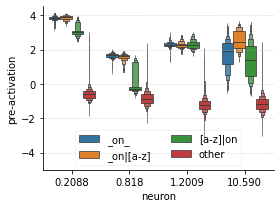

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))


on_family_df, on_neuron_cols = make_unigram_feature_family_data(
            ds, best_df, unigram_df, decoded_vocab, 'on_unigram')
plot_unigram_neuron_family_boxenplot(on_family_df, on_neuron_cols, 'on_unigram', ax=ax)
ax.set_ylabel('pre-activation')

ax.grid(axis='y', alpha=0.4, linestyle='--')


# make legend 4 cols and remove title
ax.legend(title='', ncols=2, loc='lower center').get_frame().set_alpha(0.2)
# change legend labels to be more descriptive
class_labels = ['_on_', '_on|[a-z]', '[a-z]|on', 'other']
for ix, label in enumerate(class_labels):
    ax.get_legend().get_texts()[ix].set_text(label)

ax.set_ylim(bottom=-5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('')

for tick in ax.get_xticklabels():
    tick.set_text('L' + tick.get_text())

plt.tight_layout()

plt.savefig('figures/main_on_unigram.png', dpi=150, bbox_inches='tight')

In [18]:
already_shown = duplicate_unigram_families + ['a_unigram', 'an_unigram']
unigram_plot_neurons = best_df.query('feature not in @already_shown').head(30)

In [19]:
unigram_plot_neurons

,layer,neuron,variance_reduction,feature
0,0,3270,0.986861,to_unigram
3,0,3953,0.967139,contains_comma
4,1,116,0.962920,to_unigram
6,1,2504,0.955042,is_one_digit
8,0,2962,0.949867,contains_period
10,1,1729,0.936604,is_possessive_pronoun
11,1,1304,0.934560,contains_comma
14,0,916,0.911413,and_unigram
21,0,2234,0.878832,is_neutral_pronoun
23,1,3813,0.874134,from_unigram


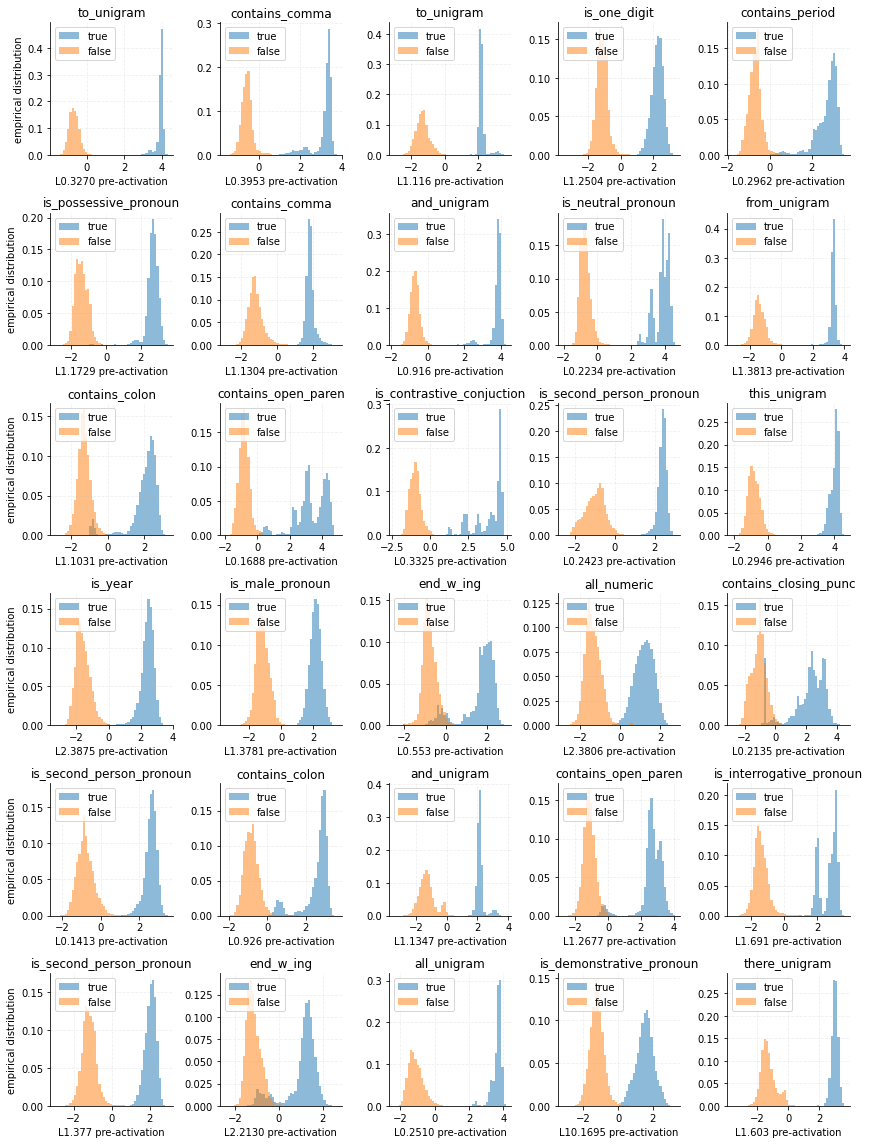

In [34]:
fig, axs = plt.subplots(6, 5, figsize=(12, 16))

for ix, (l, n, v, feature) in enumerate(unigram_plot_neurons.values):
    ax = axs[ix // 5, ix % 5]

    if feature in unigram_df.columns:
        family_df, neuron_cols = make_unigram_neuron_plot_data(
            ds, unigram_plot_neurons, unigram_df, decoded_vocab, l, n, feature)
    
        plot_vocab_neuron(family_df, neuron_cols, feature, ax=ax)
    else:
        family_df, neuron_cols = make_unigram_neuron_plot_data(
            ds, unigram_plot_neurons, vocab_df, decoded_vocab, l, n, feature)
    
        plot_vocab_neuron(family_df, neuron_cols, feature, ax=ax)

    ax.set_xlabel(f'L{l}.{n} pre-activation')

    if ix % 5 == 0:
        ax.set_ylabel('empirical distribution')

    ax.grid(alpha=0.2, linestyle='--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(feature)

plt.tight_layout()

plt.savefig('figures/unigram_nonduplicate_appendix.png', dpi=75, bbox_inches='tight')

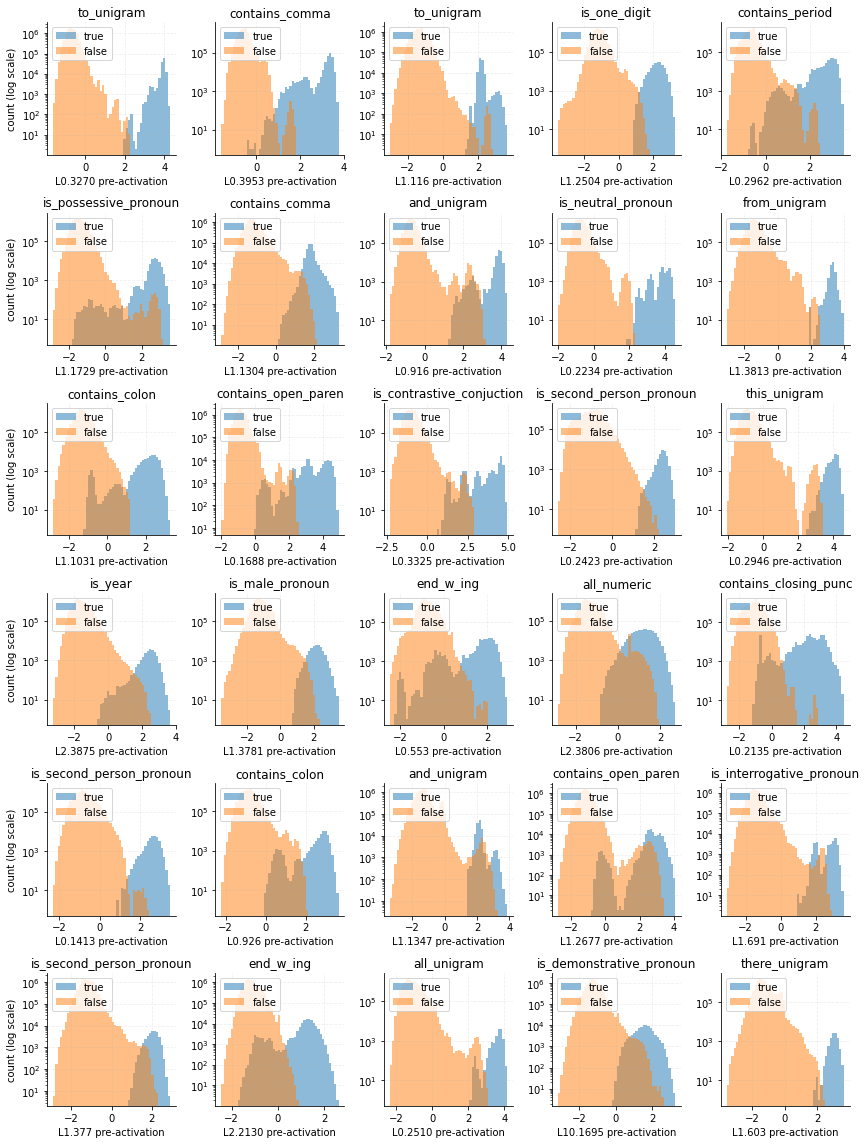

In [20]:
fig, axs = plt.subplots(6, 5, figsize=(12, 16))

for ix, (l, n, v, feature) in enumerate(unigram_plot_neurons.values):
    ax = axs[ix // 5, ix % 5]

    if feature in unigram_df.columns:
        family_df, neuron_cols = make_unigram_neuron_plot_data(
            ds, unigram_plot_neurons, unigram_df, decoded_vocab, l, n, feature)
    
    else:
        family_df, neuron_cols = make_unigram_neuron_plot_data(
            ds, unigram_plot_neurons, vocab_df, decoded_vocab, l, n, feature)
    
    plot_vocab_neuron(family_df, neuron_cols, feature, ax=ax, logy=True, plot_dist=False)

    ax.set_xlabel(f'L{l}.{n} pre-activation')

    if ix % 5 == 0:
        ax.set_ylabel('count (log scale)')

    ax.grid(alpha=0.2, linestyle='--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(feature)

plt.tight_layout()

plt.savefig('figures/unigram_nonduplicate_log_appendix.png', dpi=75, bbox_inches='tight')